# Aperture extraction on an extended source
In this notebook we apply a simple aperture extraction algorithm, based on the detector2cube coordinate transformations, to extract a 1d spectrum from a plane MRS detector image.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [11]:
import funcs
import mrsobs

import numpy as np

We load images of the:
* MTS 800K BB extended source

In [3]:
# Define paths to data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir  = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_source_sci,ext_source_bkg = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')

We subtract background exposures where available.

In [4]:
# perform transform
ext_source_bkgsubtr = ext_source_sci-ext_source_bkg

We extract a detector pixel trace based on:
* the slice number and along-slice position (required geometric distortion calibration information for the latter).

In [5]:
d2cMaps   = funcs.load_obj('d2cMaps_band'+band,path=d2cMapDir)
nslices   = d2cMaps['nslices']

# Pixel trace in MRS slice
#-- extended source
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=nslices/2,alpha_pos=0.)

Let's look at the 2D images and the extracted spectra through the pixel traces.

In [6]:
fringe_img = funcs.get_cdps(band,cdpDir)[0]
photom_img = funcs.get_cdps(band,cdpDir)[1]

In [7]:
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

<IPython.core.display.Javascript object>


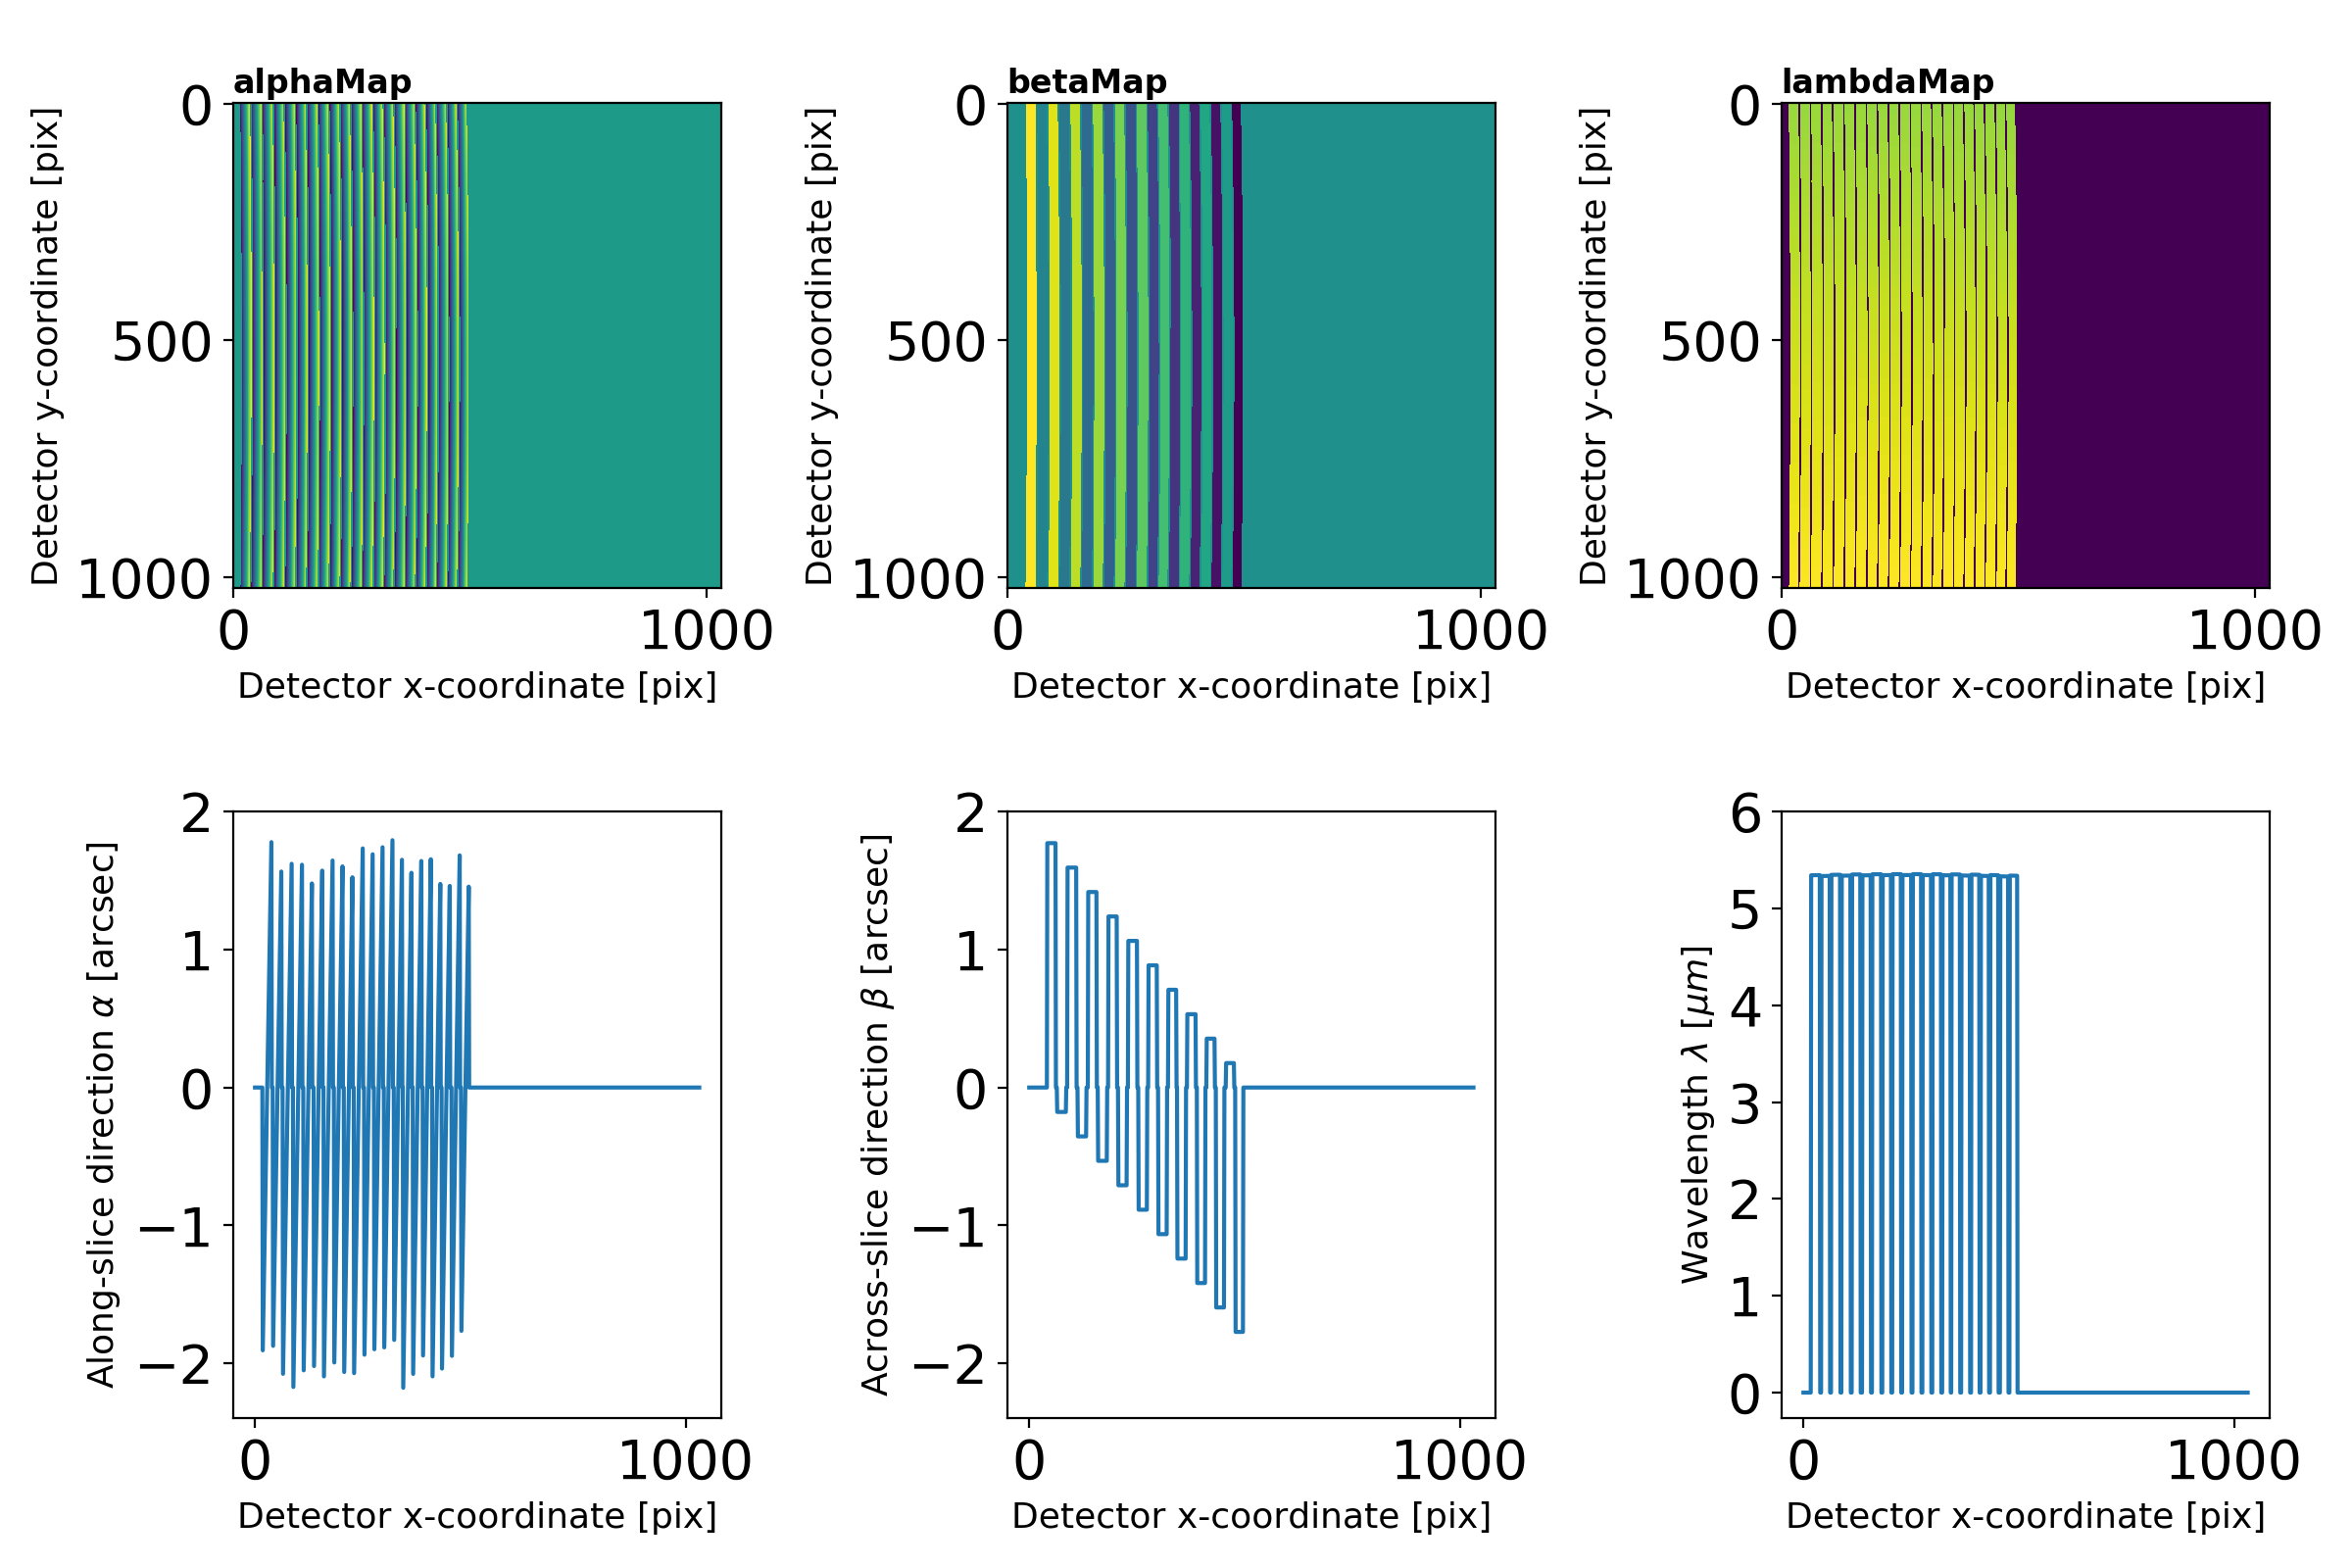

<IPython.core.display.Javascript object>


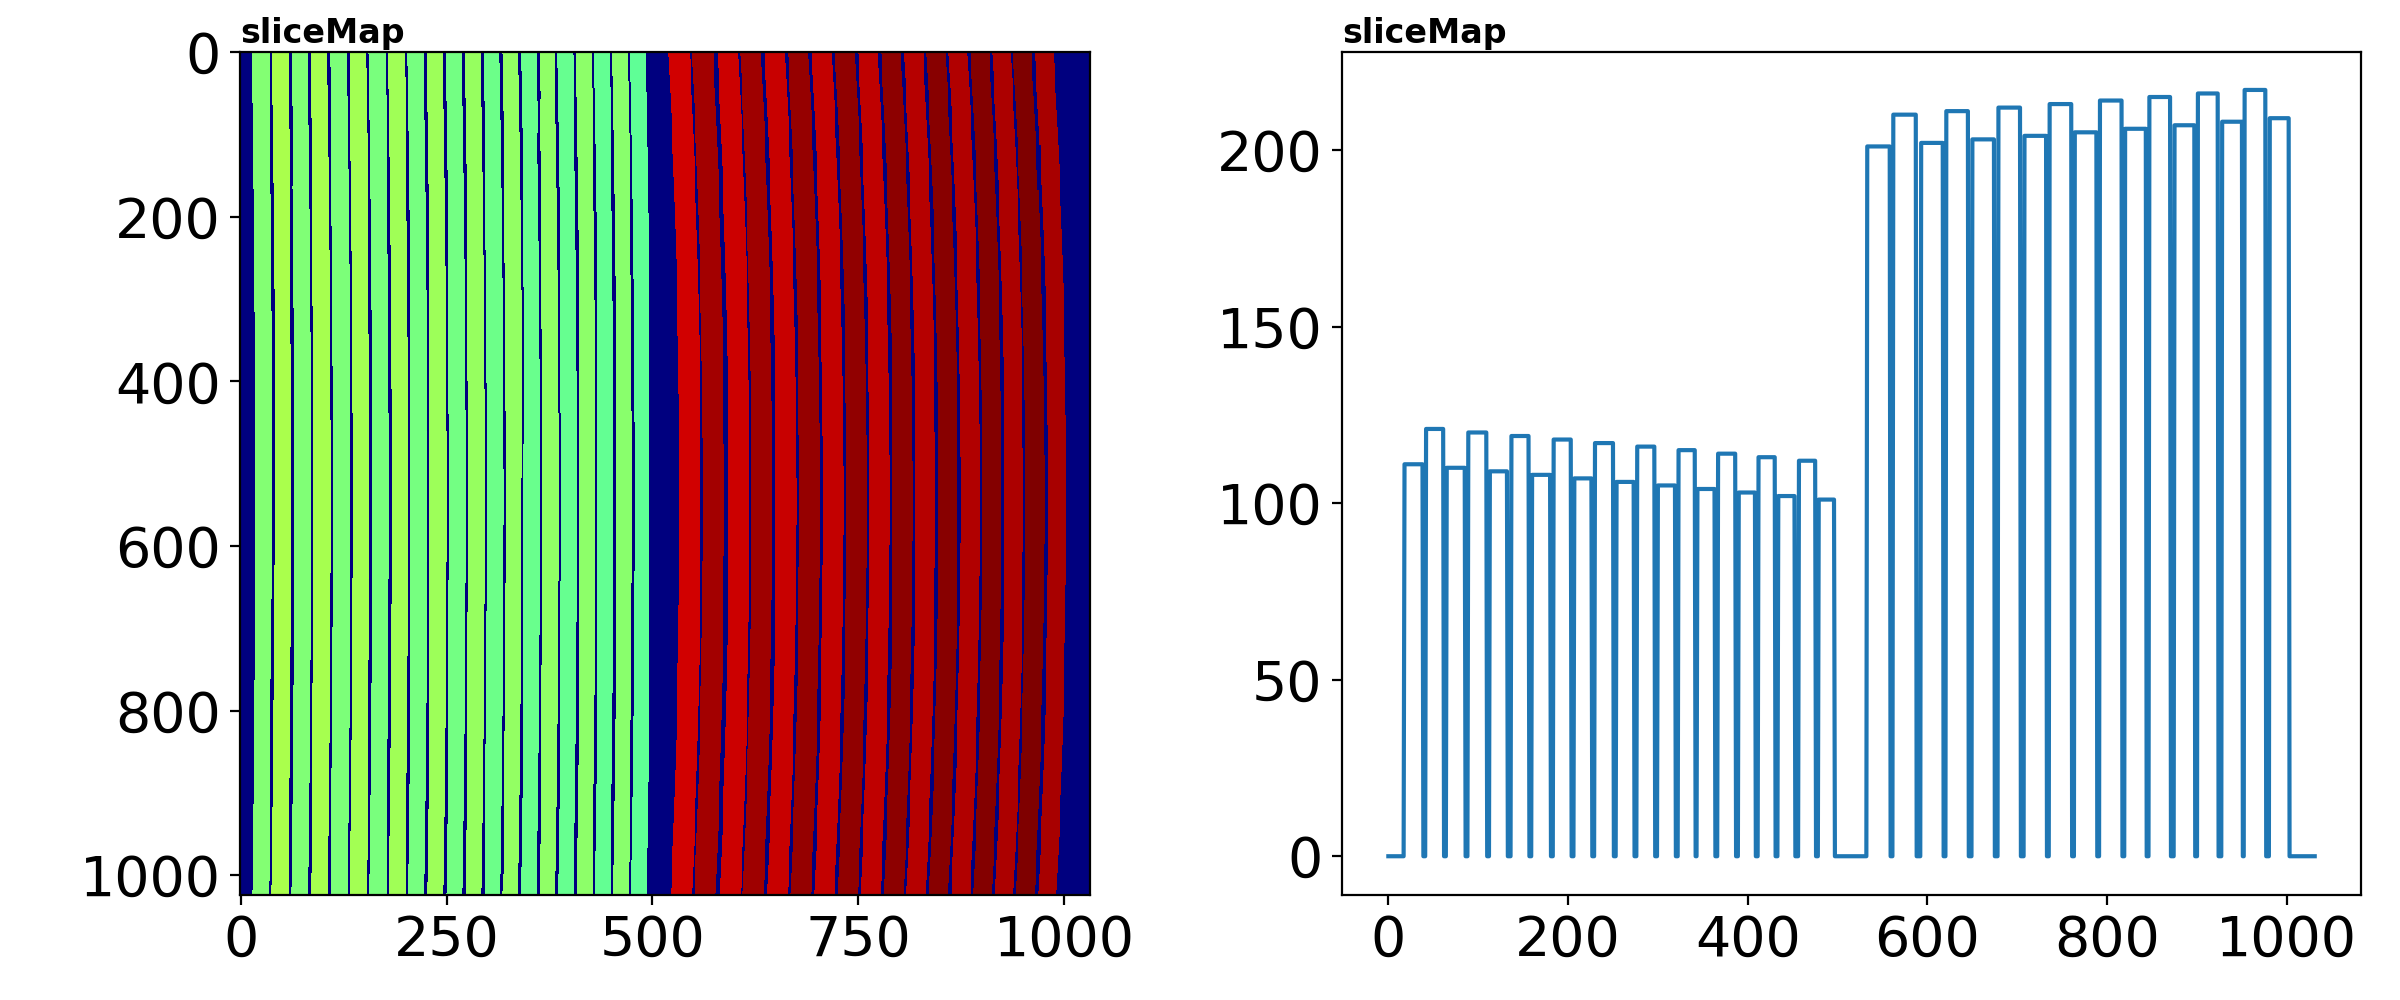

In [8]:
# First the reference distortion maps. These are the 3D spatial-and-spectral coordinates of the MRS integral field unit (IFU), projected on the detector 2D plane.
# Note that as a result of the 3D to 2D projection, every pixel has three coordinates! (a bit confusing I know, but that is how slicer IFUs work)
fig,axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0,0].imshow(d2cMaps['alphaMap'],interpolation='nearest')
axs[0,0].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[0,0].set_ylabel('Detector y-coordinate [pix]',fontsize=13)
axs[0,0].annotate('alphaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0,1].imshow(d2cMaps['betaMap'],interpolation='nearest')
axs[0,1].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[0,1].set_ylabel('Detector y-coordinate [pix]',fontsize=13)
axs[0,1].annotate('betaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0,2].imshow(d2cMaps['lambdaMap'],interpolation='nearest')
axs[0,2].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[0,2].set_ylabel('Detector y-coordinate [pix]',fontsize=13)
axs[0,2].annotate('lambdaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# Taking a horizontal cut through the detector will perhaps yield more insight on how the cube coordinates vary in pixel space.
# As a quick summary, every slice corresponds to a single beta coordinates (and vice-versa), alpha changes (more or less) linearly in the horizontal direction of a slice,
# and finally the wavelength is (more or less) constant in the horizontal direction of a slice. The wavelength (dispersion) direction actually follows the vertical axis.
# Note though that when I mentioned "more or less" for the alpha and lambda coordinates' linearity, that is because this is not exactly true. 
# Because of the distortion introduced by the MRS optics (e.g. slicer), the slices are curved on the detector, and consequently 
# there is a non-linearity component to the alpha and lambda coordinates when inspected in horizontal and vertical directions (equivalent to pixel rows and pixel columns). This effect should not be overlooked!
row = 512
axs[1,0].plot(d2cMaps['alphaMap'][row,:])
axs[1,0].set_yticks([-2,-1,0,1,2])
axs[1,0].set_ylim(-2.4,2)
axs[1,0].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[1,0].set_ylabel(r'Along-slice direction $\alpha$ [arcsec]',fontsize=13)
axs[1,1].plot(d2cMaps['betaMap'][row,:])
axs[1,1].set_ylim(-2.4,2)
axs[1,1].set_yticks([-2,-1,0,1,2])
axs[1,1].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[1,1].set_ylabel(r'Across-slice direction $\beta$ [arcsec]',fontsize=13)
axs[1,2].plot(d2cMaps['lambdaMap'][row,:])
axs[1,2].set_yticks([0,1,2,3,4,5,6])
axs[1,2].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[1,2].set_ylabel(r'Wavelength $\lambda$ [$\mu m$]',fontsize=13)
plt.tight_layout()
plt.savefig('/Users/ioannisa/Desktop/alpha_beta_lambda_2D.eps', format='eps', dpi=100)

# Just as the beta coordinate jumps up and down, the slice map does so too. Slices on the detector (positions in the MRS FOV) are actually interleaved.
# This means that two nearby slices on the detector are *not* neighboring in the MRS FOV. In fact that is far from the case. One slice can be at the edge of the FOV, while the next slice would be located at the center of the FOV.
fig,axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(d2cMaps['sliceMap'],cmap='jet', interpolation='nearest')
axs[0].annotate('sliceMap', xy=(0.0, 1.01), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].plot(d2cMaps['sliceMap'][row,:])
axs[1].annotate('sliceMap', xy=(0.0, 1.01), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()

<IPython.core.display.Javascript object>


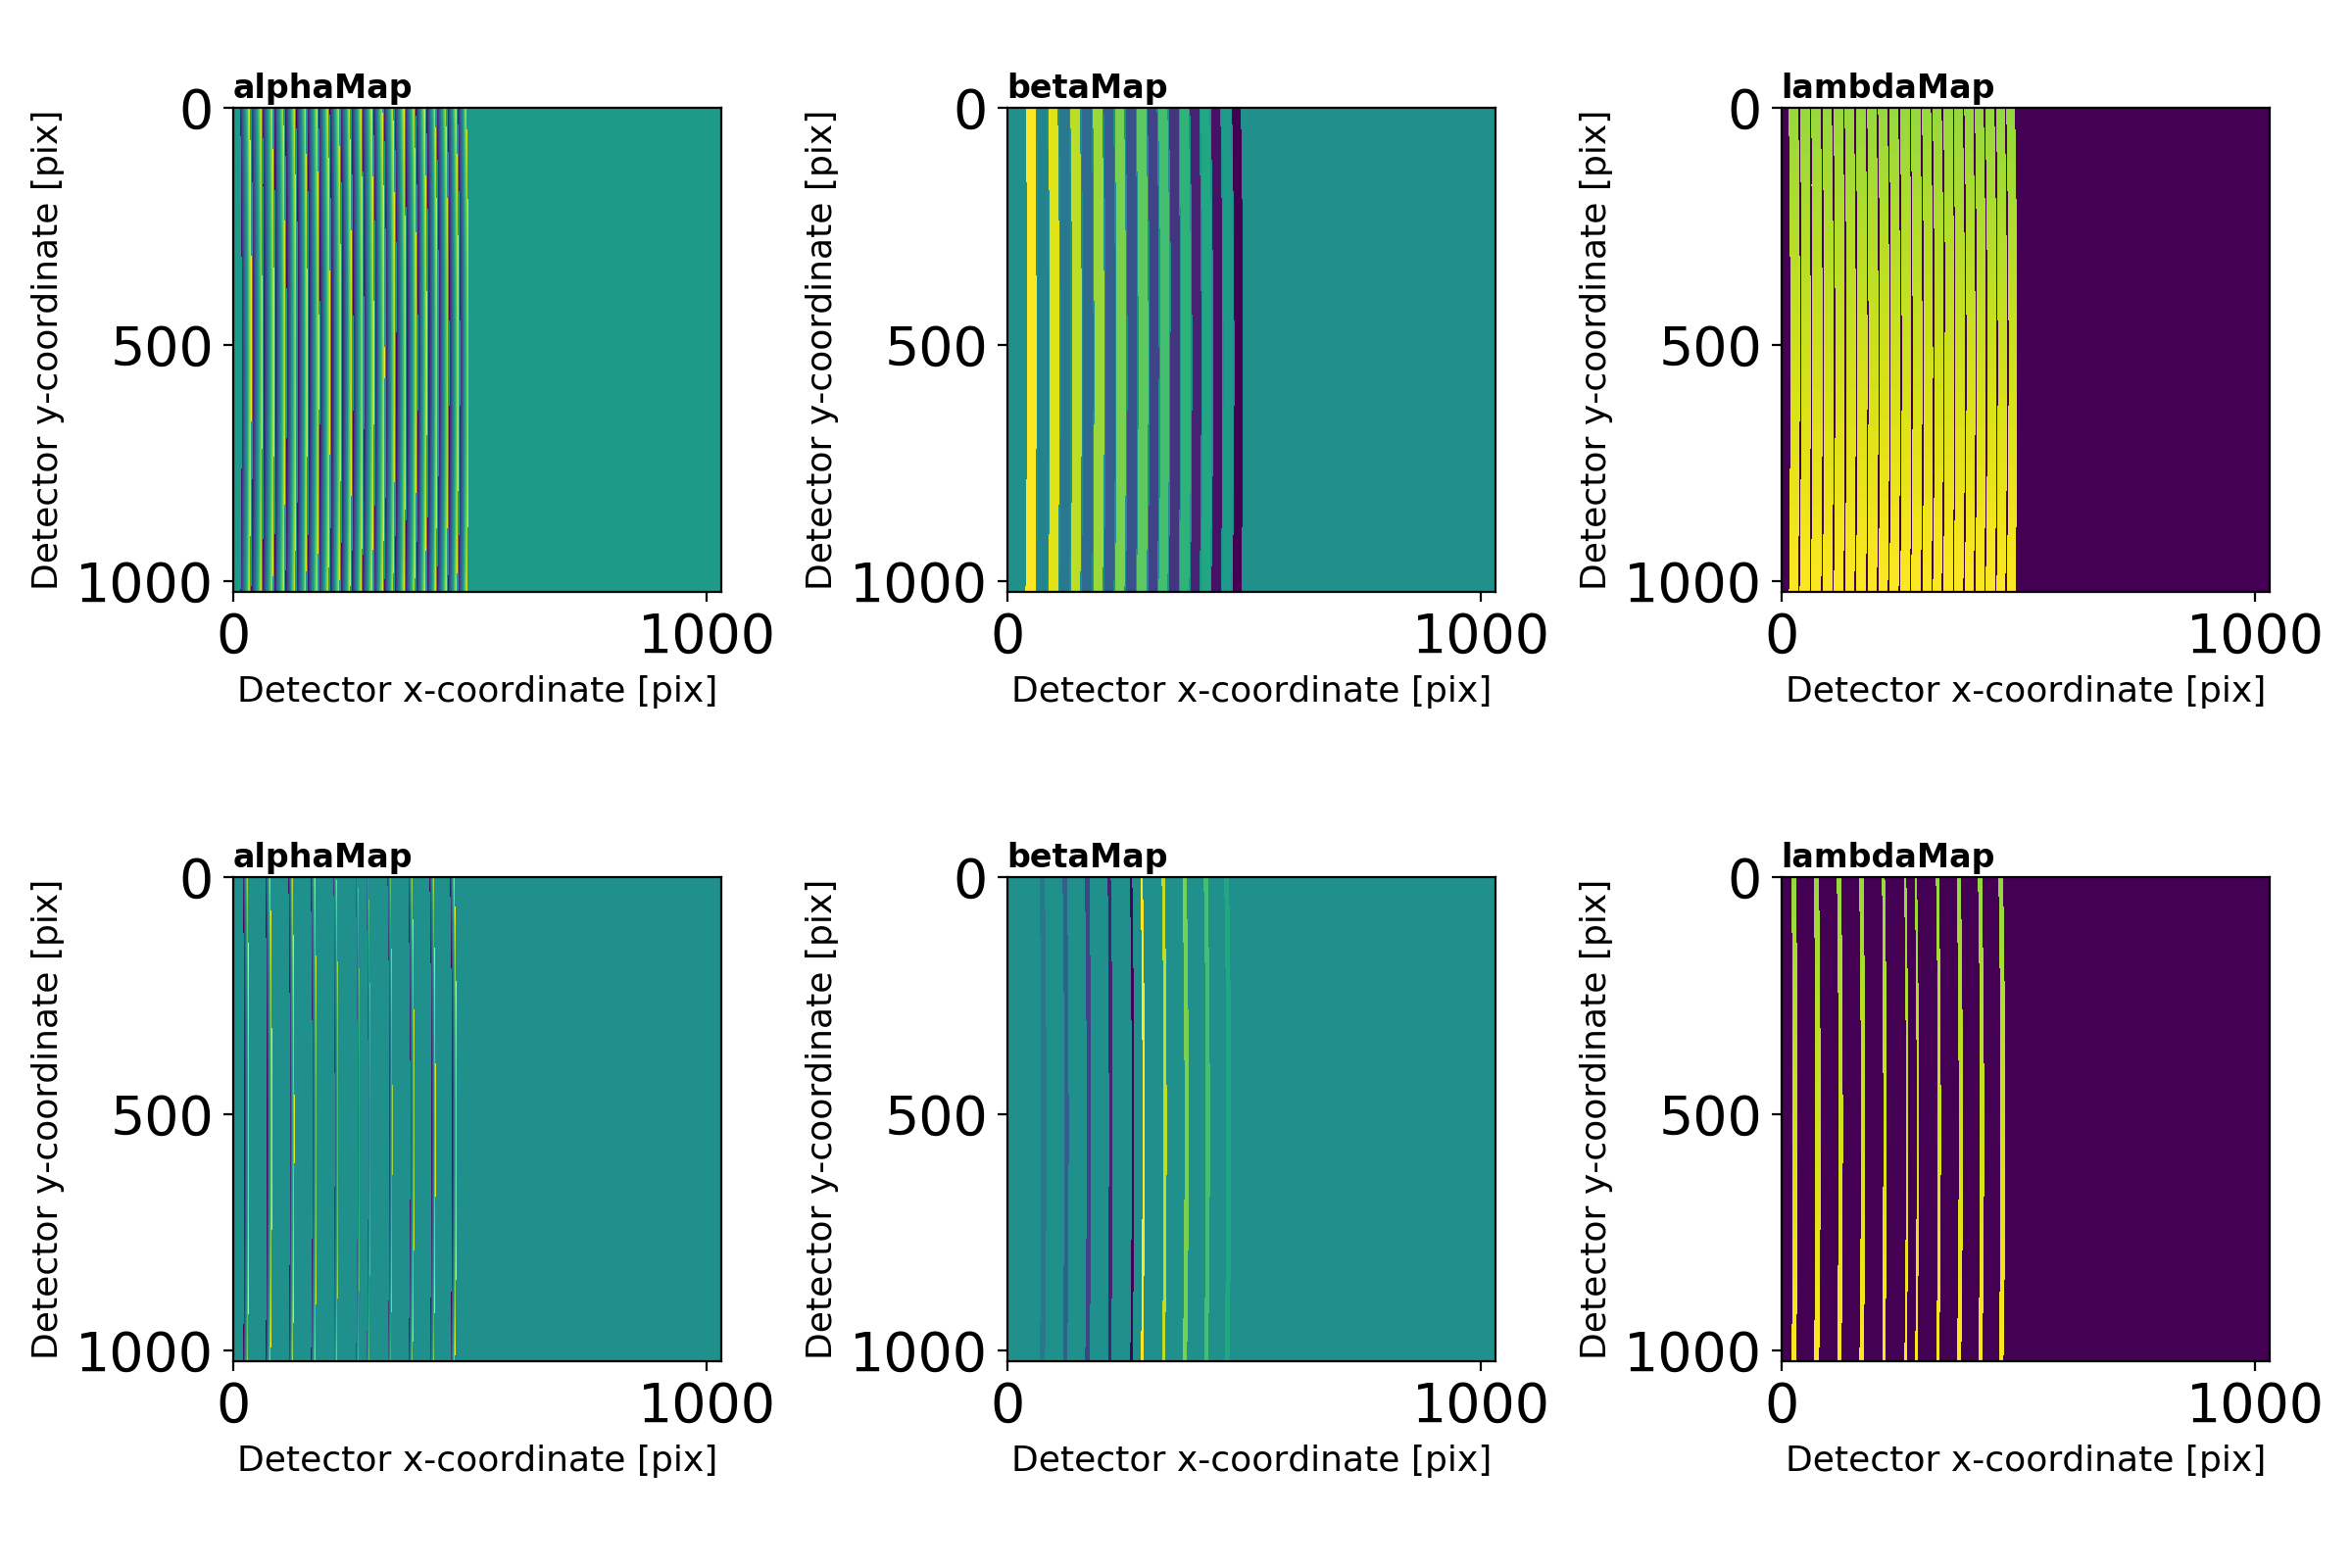

In [9]:
fig,axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0,0].imshow(d2cMaps['alphaMap'],interpolation='nearest')
axs[0,0].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[0,0].set_ylabel('Detector y-coordinate [pix]',fontsize=13)
axs[0,0].annotate('alphaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0,1].imshow(d2cMaps['betaMap'],interpolation='nearest')
axs[0,1].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[0,1].set_ylabel('Detector y-coordinate [pix]',fontsize=13)
axs[0,1].annotate('betaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0,2].imshow(d2cMaps['lambdaMap'],interpolation='nearest')
axs[0,2].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[0,2].set_ylabel('Detector y-coordinate [pix]',fontsize=13)
axs[0,2].annotate('lambdaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

alphaMap = d2cMaps['alphaMap']
betaMap = d2cMaps['betaMap']
lambdaMap = d2cMaps['lambdaMap']

sel = (alphaMap**2. + betaMap**2. < 1.**2.)
alphaMap[~sel] = 0.
betaMap[~sel] = 0.
lambdaMap[~sel] = 0.

axs[1,0].imshow(d2cMaps['alphaMap'],interpolation='nearest')
axs[1,0].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[1,0].set_ylabel('Detector y-coordinate [pix]',fontsize=13)
axs[1,0].annotate('alphaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1,1].imshow(d2cMaps['betaMap'],interpolation='nearest')
axs[1,1].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[1,1].set_ylabel('Detector y-coordinate [pix]',fontsize=13)
axs[1,1].annotate('betaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1,2].imshow(d2cMaps['lambdaMap'],interpolation='nearest')
axs[1,2].set_xlabel('Detector x-coordinate [pix]',fontsize=13)
axs[1,2].set_ylabel('Detector y-coordinate [pix]',fontsize=13)
axs[1,2].annotate('lambdaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()
plt.savefig('/Users/ioannisa/Desktop/alpha_beta_lambda_2D_apex.eps', format='eps', dpi=100)

<IPython.core.display.Javascript object>


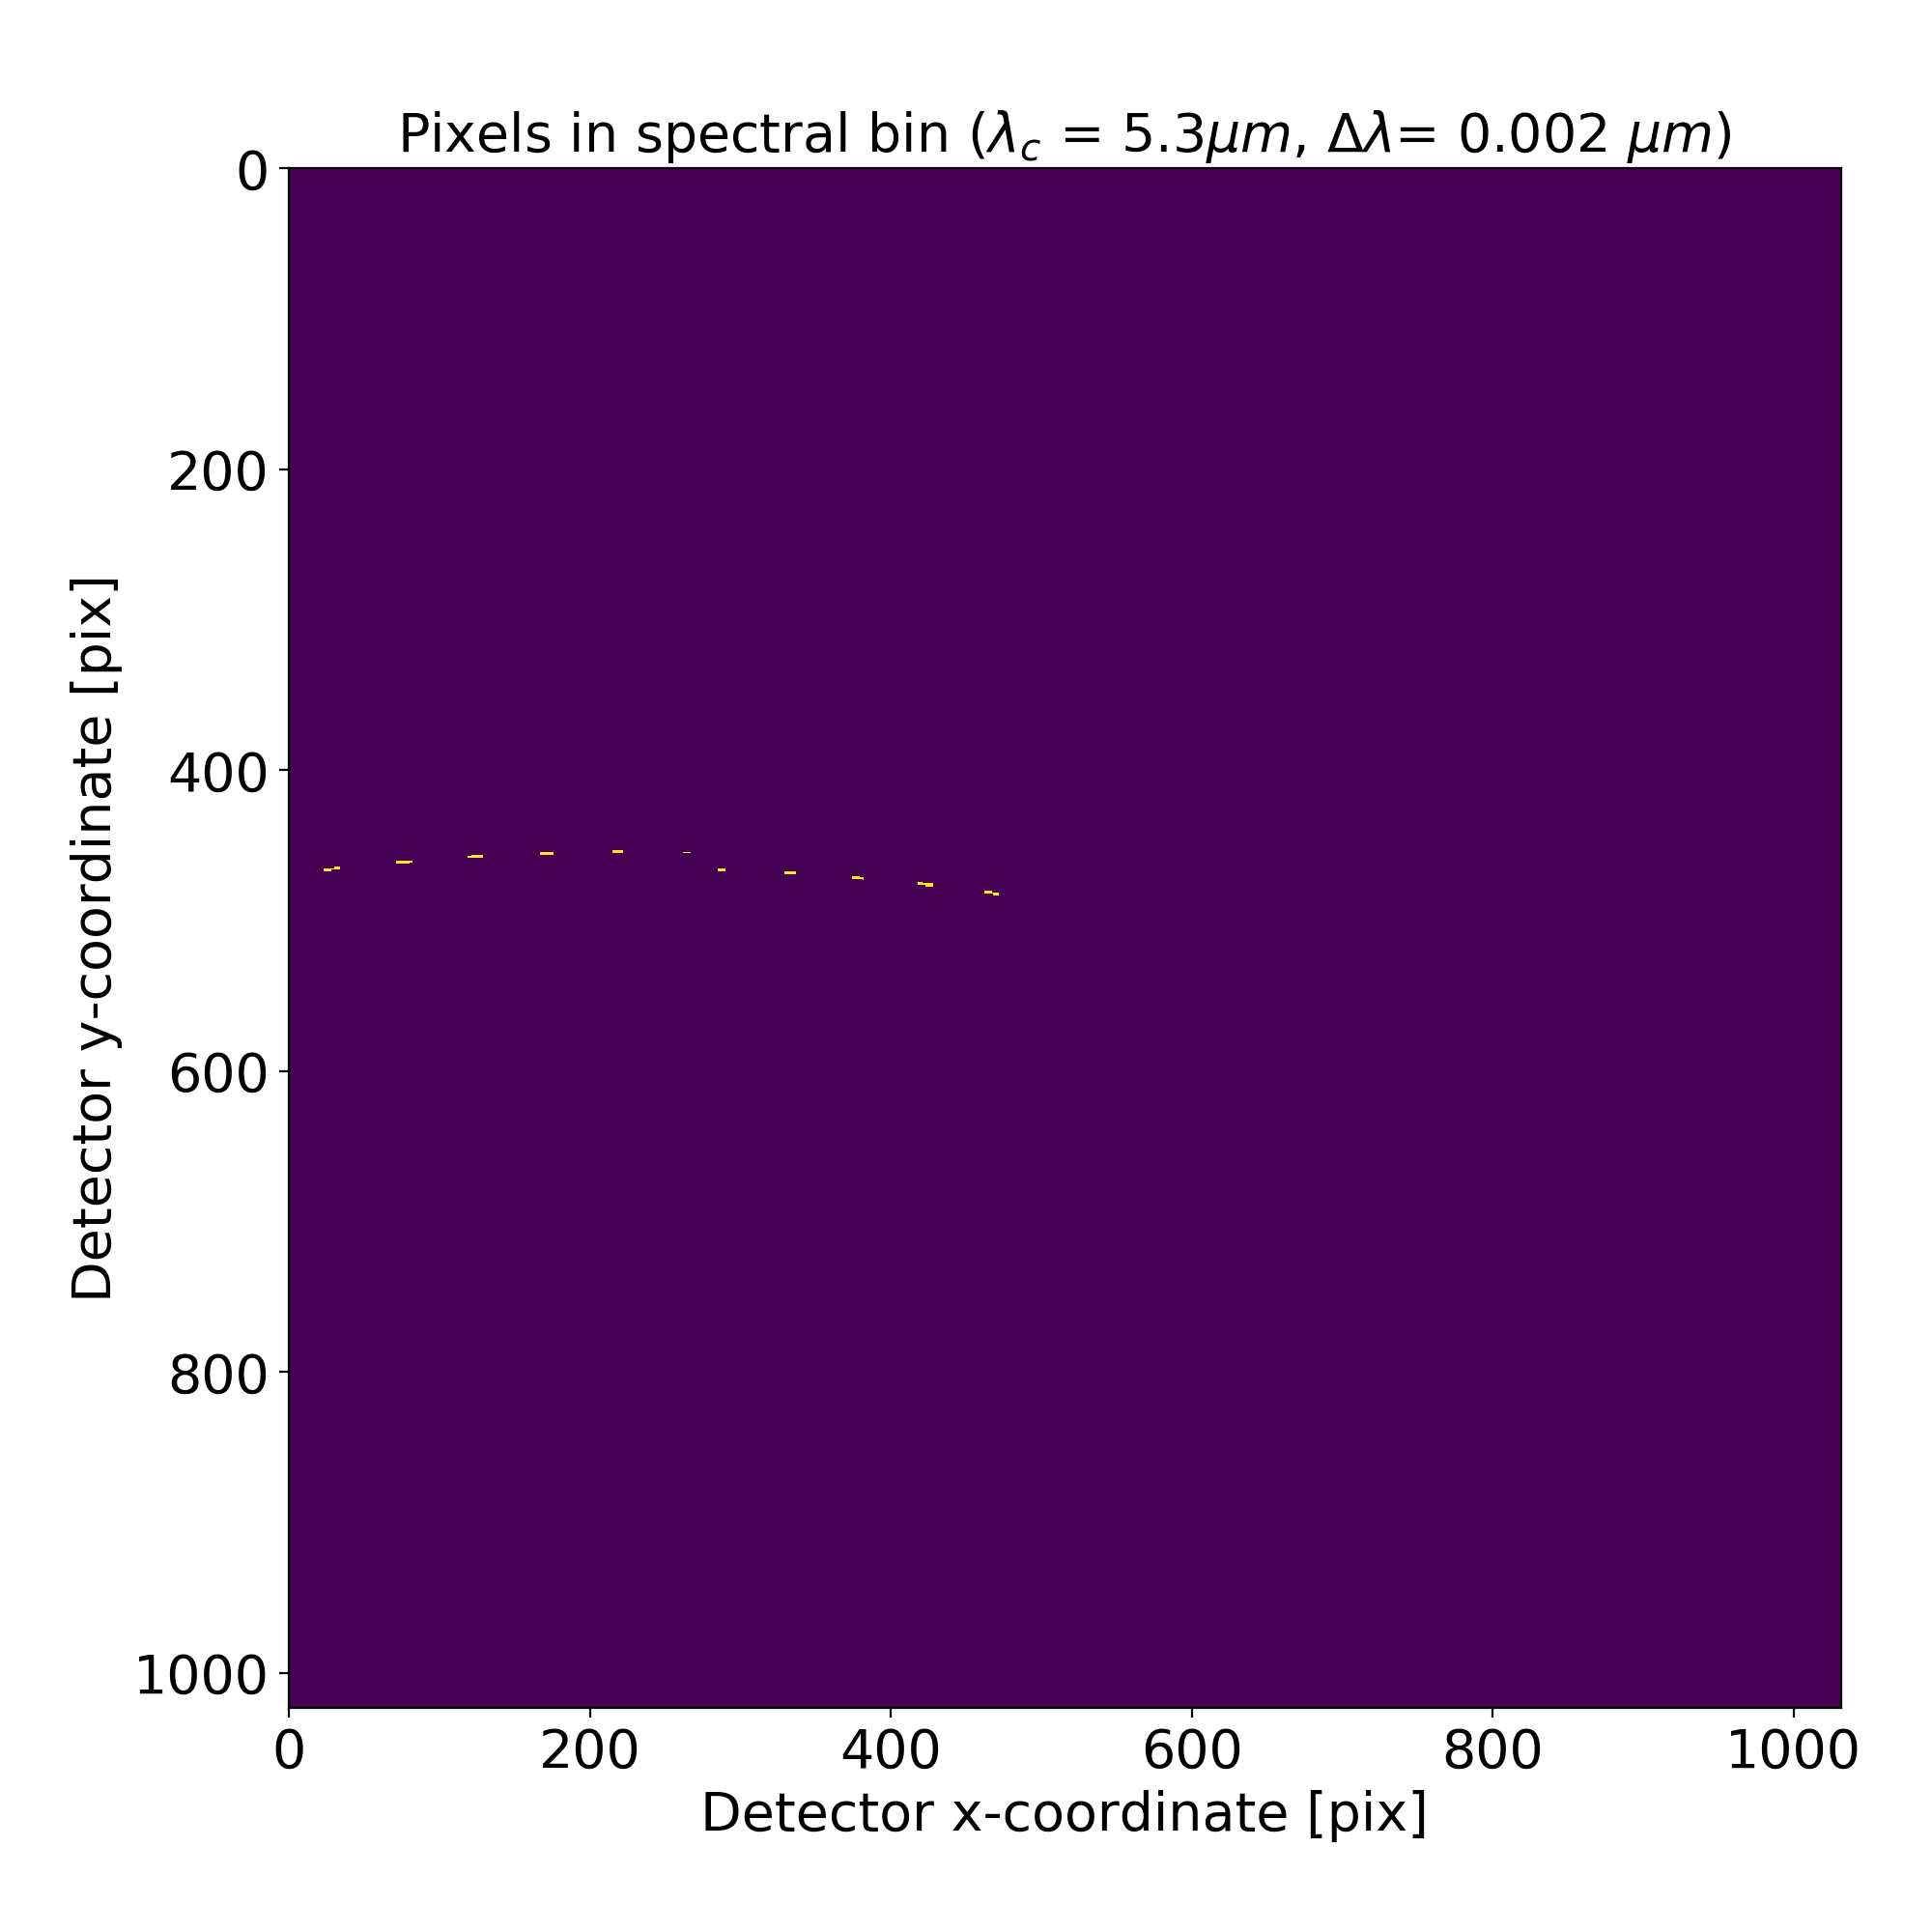

In [12]:
specres_table = funcs.get_cdps(band,cdpDir)[4]
lambcens,lambfwhms = funcs.spectral_gridding(band=band,d2cMaps=d2cMaps,specres_table=specres_table)

ibin = len(lambcens)/2 +1
selectedpixelMap = np.zeros((1024,1032))
selectedpixelMap[(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)] = 1.
plt.figure(figsize=(10,10))
plt.imshow(selectedpixelMap,interpolation='None',aspect='equal')
plt.title(r'Pixels in spectral bin ($\lambda_c$ = {}$\mu m$, $\Delta\lambda$= {} $\mu m$)'.format(round(lambcens[ibin],1),round(lambfwhms[ibin],3)))
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Detector y-coordinate [pix]')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('/Users/ioannisa/Desktop/pixels_in_bin.eps', format='eps', dpi=50)

In [33]:
from numpy import isnan
test_img = ext_source_bkgsubtr/fringe_img/photom_img
test_img[isnan(test_img)] = 0.

<IPython.core.display.Javascript object>


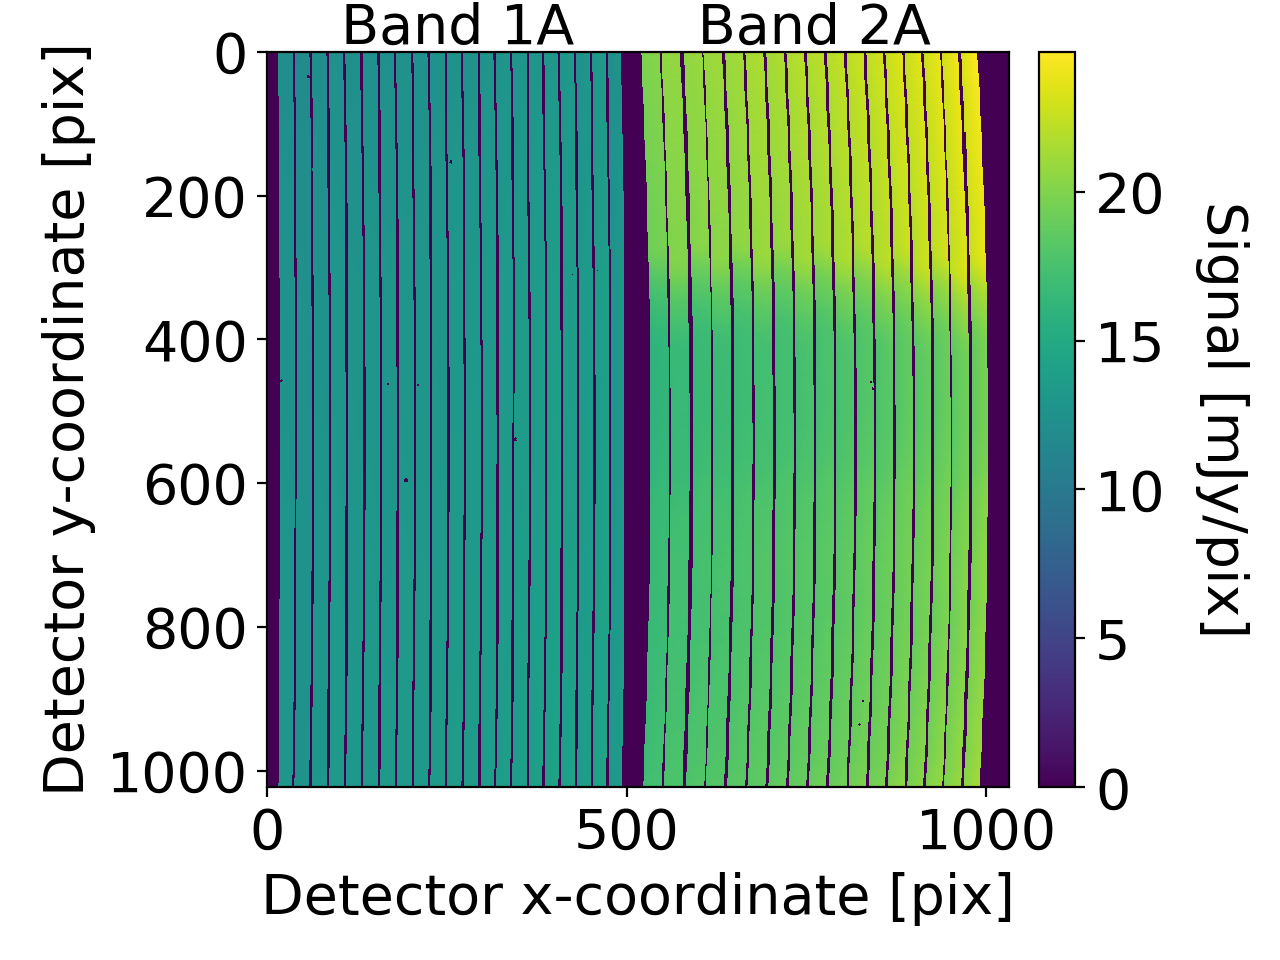

<IPython.core.display.Javascript object>


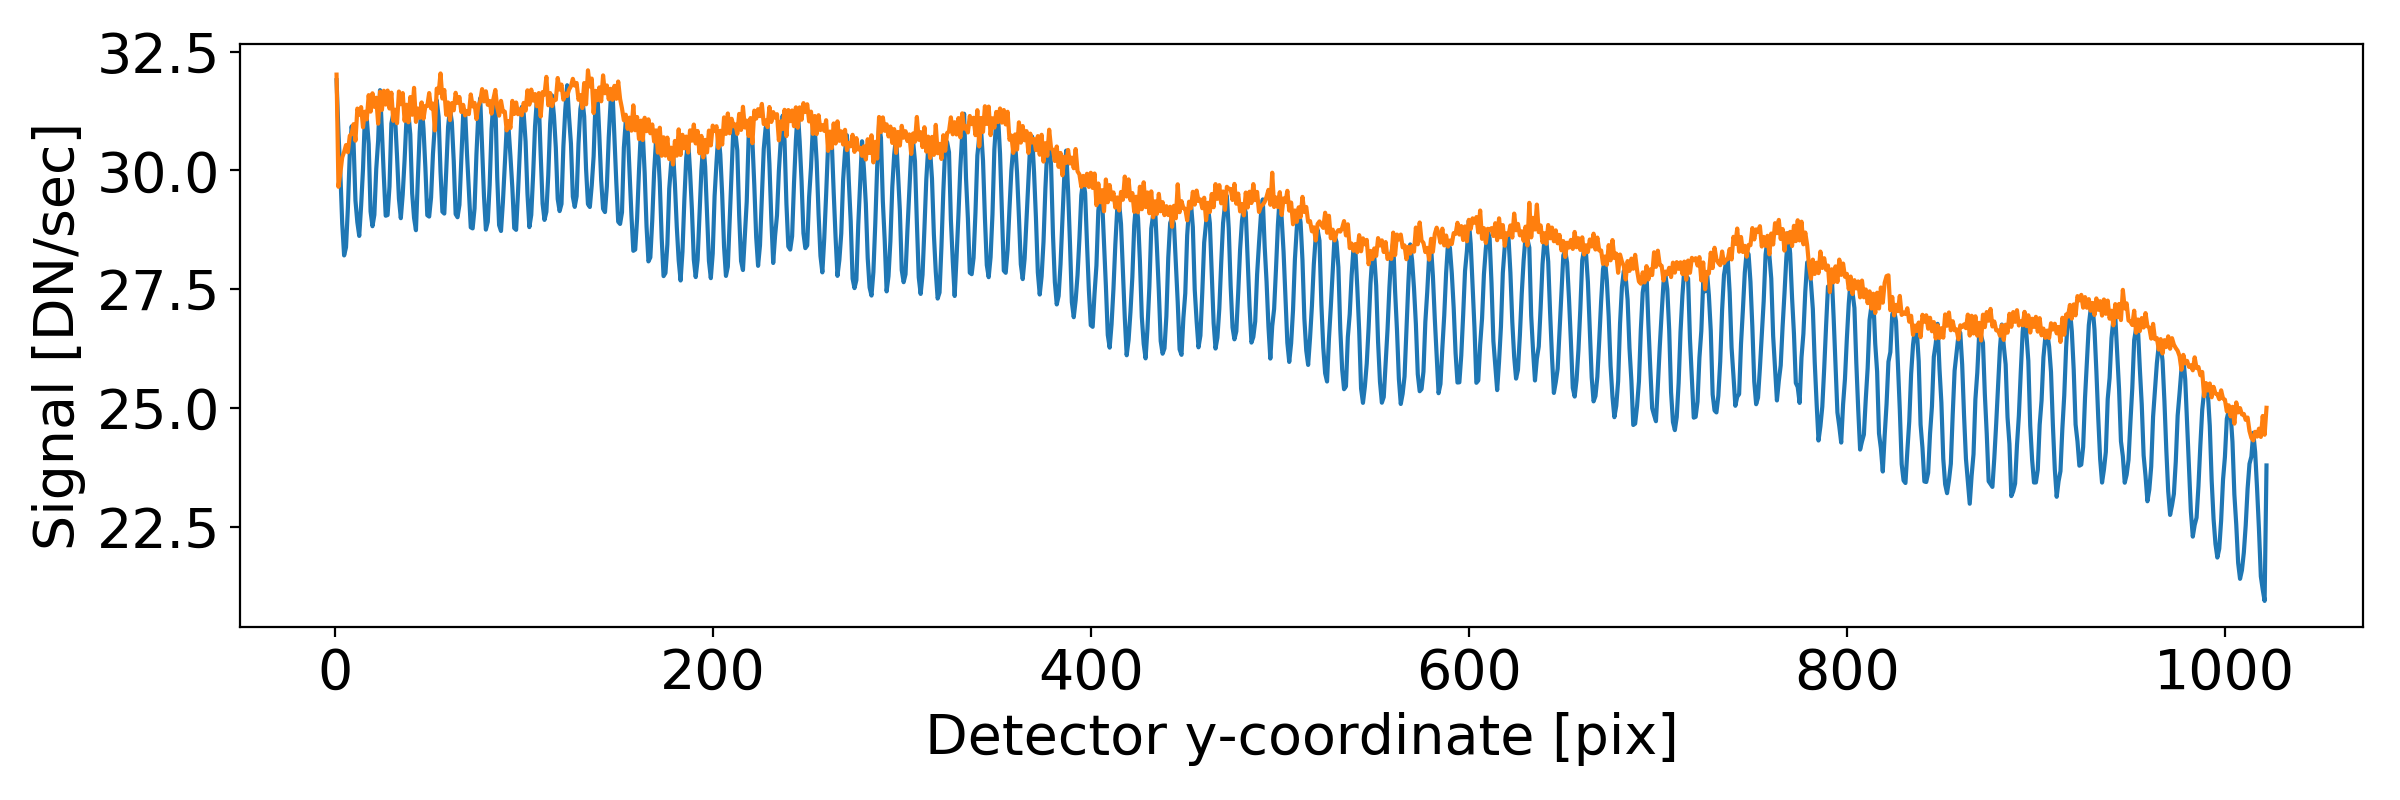

In [34]:
plt.figure()
# sc = plt.imshow(ext_source_bkgsubtr/fringe_img/photom_img)
sc = plt.imshow(test_img)
cbar = plt.colorbar(sc,pad = 0.03)
cbar.set_label(r'Signal [mJy/pix]', labelpad=30,rotation=270)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Detector y-coordinate [pix]')
plt.annotate('Band 1A       Band 2A', xy=(0.1, 1.01), xycoords='axes fraction', fontsize=20, color='k')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(ext_source_bkgsubtr[ypos,xpos])
plt.plot(ext_source_bkgsubtr[ypos,xpos]/fringe_img[ypos,xpos])
plt.xlabel('Detector y-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.tight_layout()

In [47]:
print cube_img.shape
from numpy import arange
print arange(1, 25, 1).shape

(21, 24)
(24,)


<IPython.core.display.Javascript object>


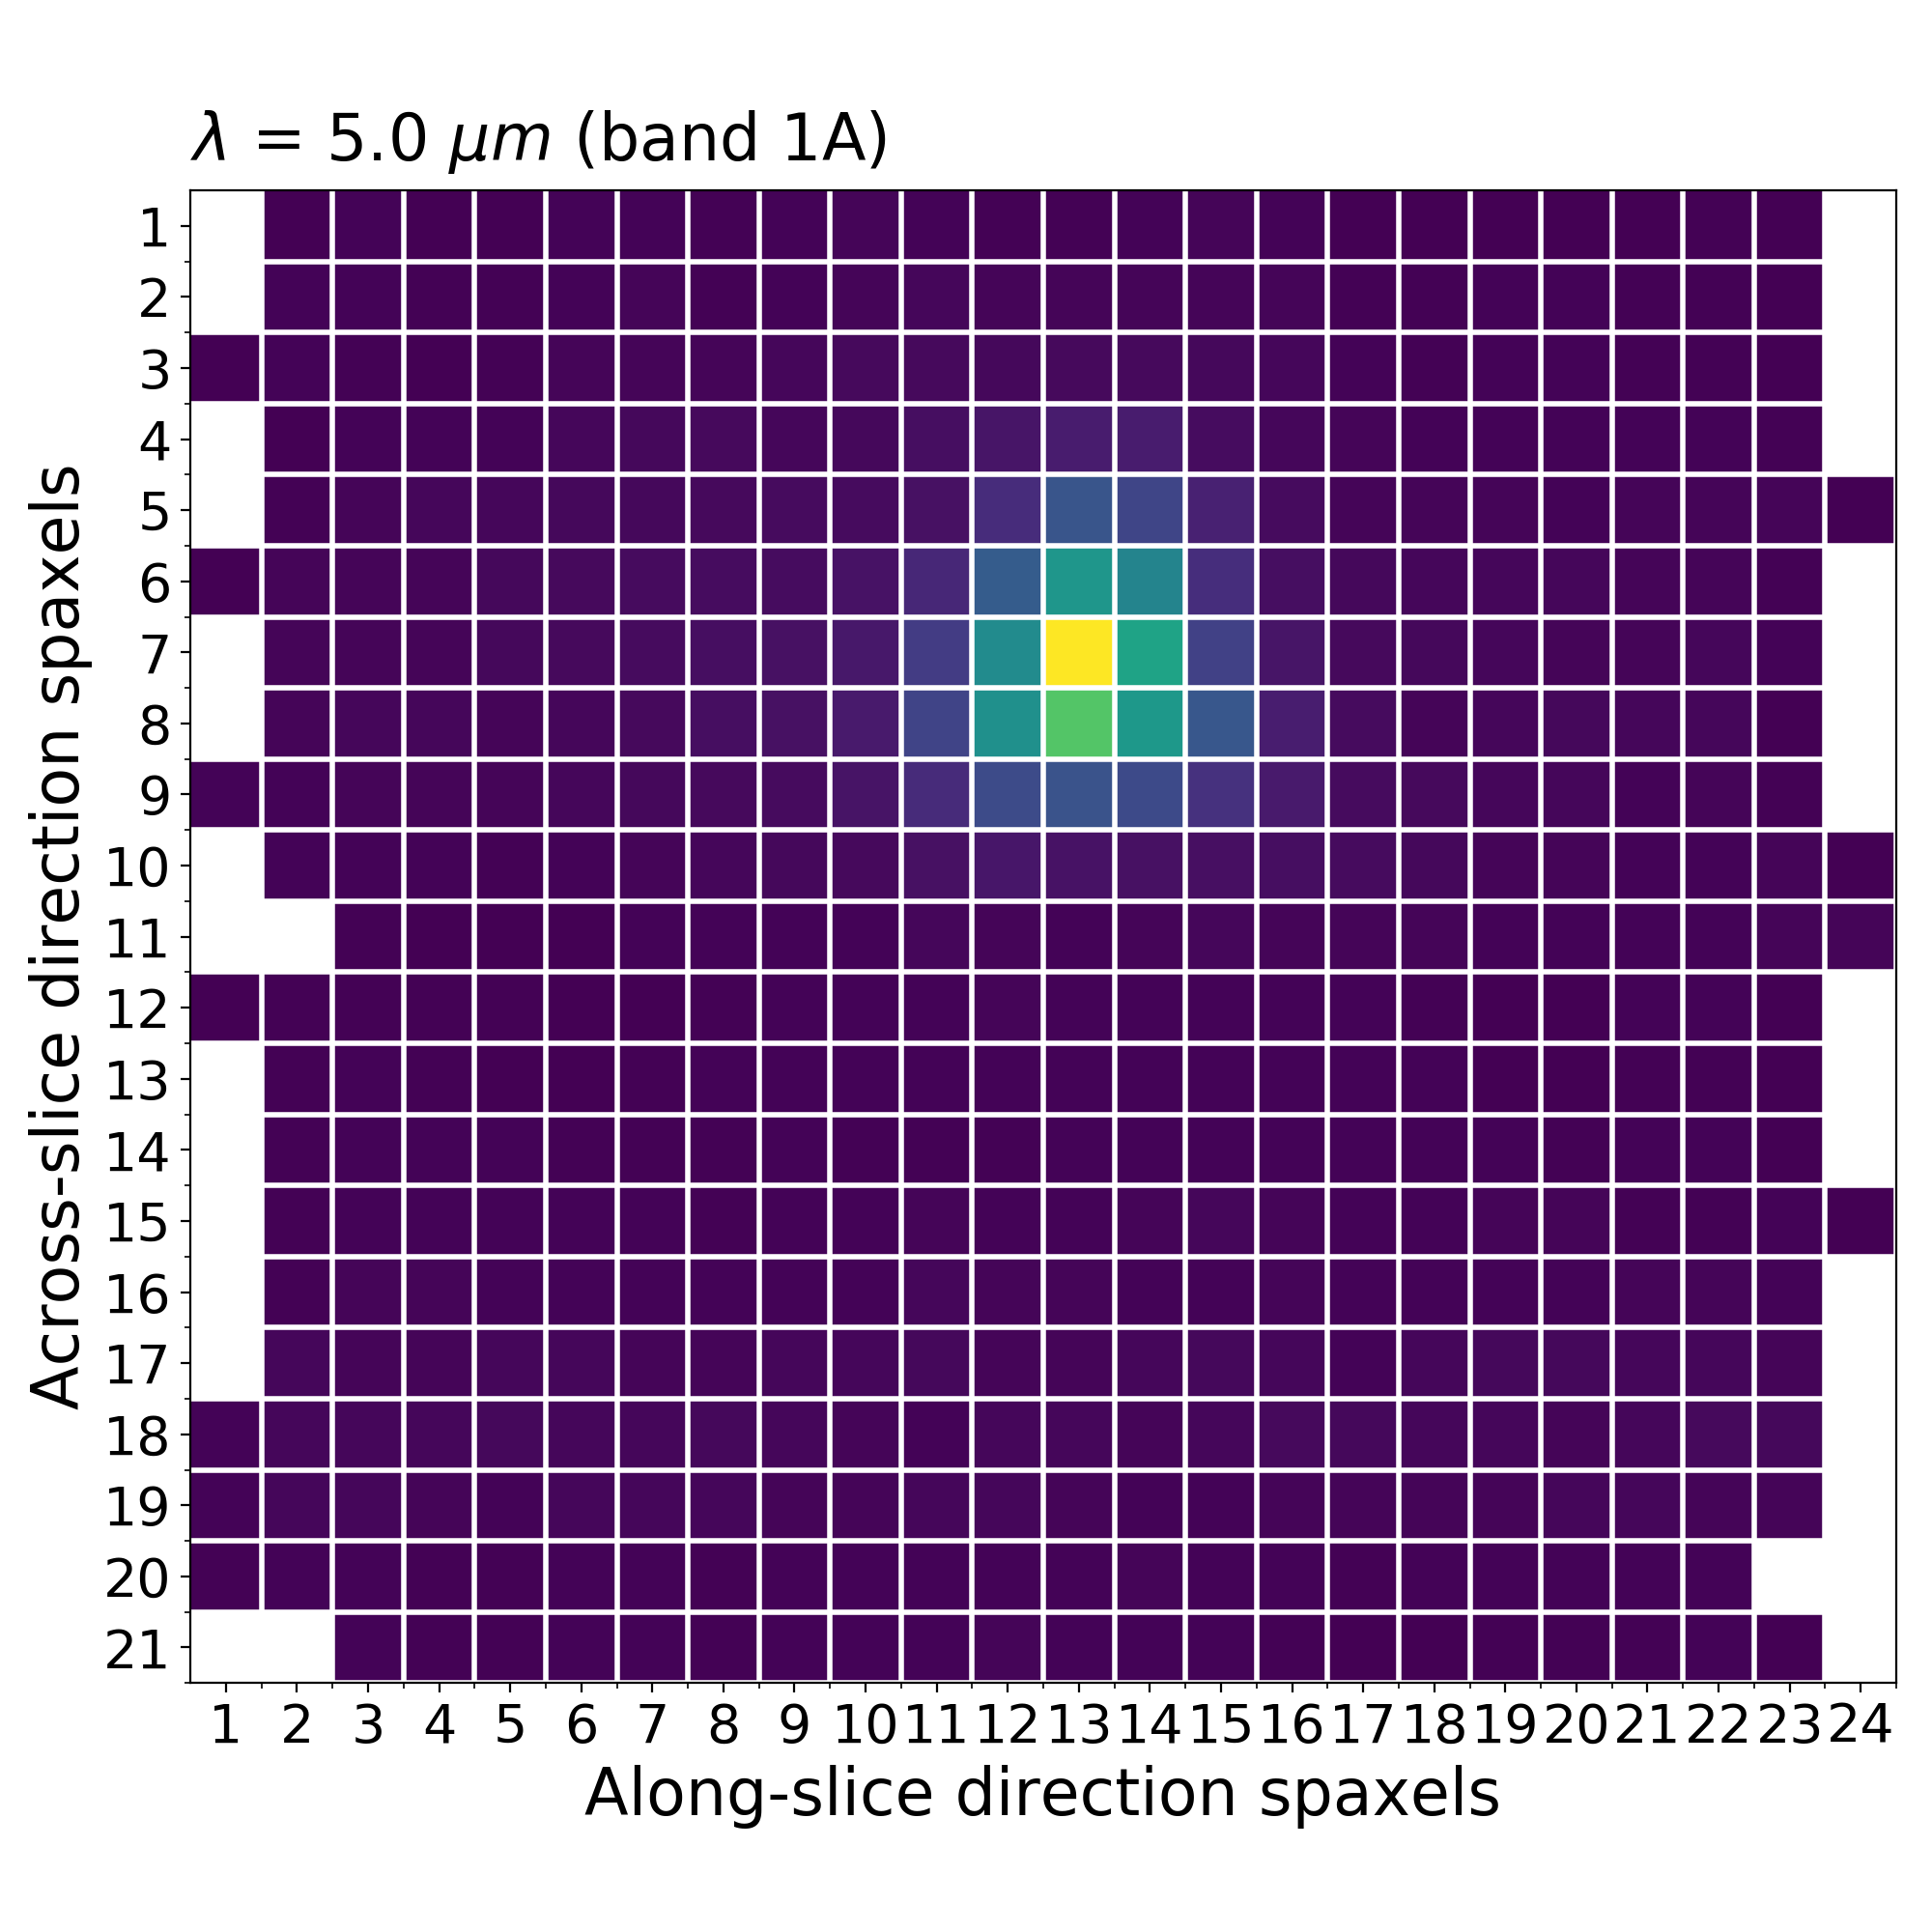

In [59]:
from astropy.io import fits
cube_img = fits.open('/Users/ioannisa/Desktop/MIRFM1T00012308_1_495_SE_2011-06-30T22h43m36_CUBE_CH1_A.fits')[0].data[500,:,:]

# plt.figure(figsize=)
# plt.imshow(cube_img,cmap='gray')
# plt.grid(which='minor', color='w', linestyle='-', linewidth=2)
# plt.tight_layout()

plt.figure(figsize=(10,10))
im = plt.imshow(cube_img,interpolation='none', aspect='equal');
plt.annotate(r'$\lambda$ = 5.0 $\mu m$ (band 1A)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=24, color='k')
plt.xlabel('Along-slice direction spaxels',fontsize=24)
plt.ylabel('Across-slice direction spaxels',fontsize=24)

ax = plt.gca();
ax = plt.gca();

# Major ticks
ax.set_xticks(arange(0, 24, 1));
ax.set_yticks(arange(0, 21, 1));

# Labels for major ticks
ax.set_xticklabels(arange(1, 25, 1));
ax.set_yticklabels(arange(1, 22, 1));

# Minor ticks
ax.set_xticks(arange(.5, 24.5, 1), minor=True);
ax.set_yticks(arange(.5, 21.5, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.tight_layout()
plt.savefig('/Users/ioannisa/Desktop/spatial_image.eps', format='eps', dpi=100)

<IPython.core.display.Javascript object>


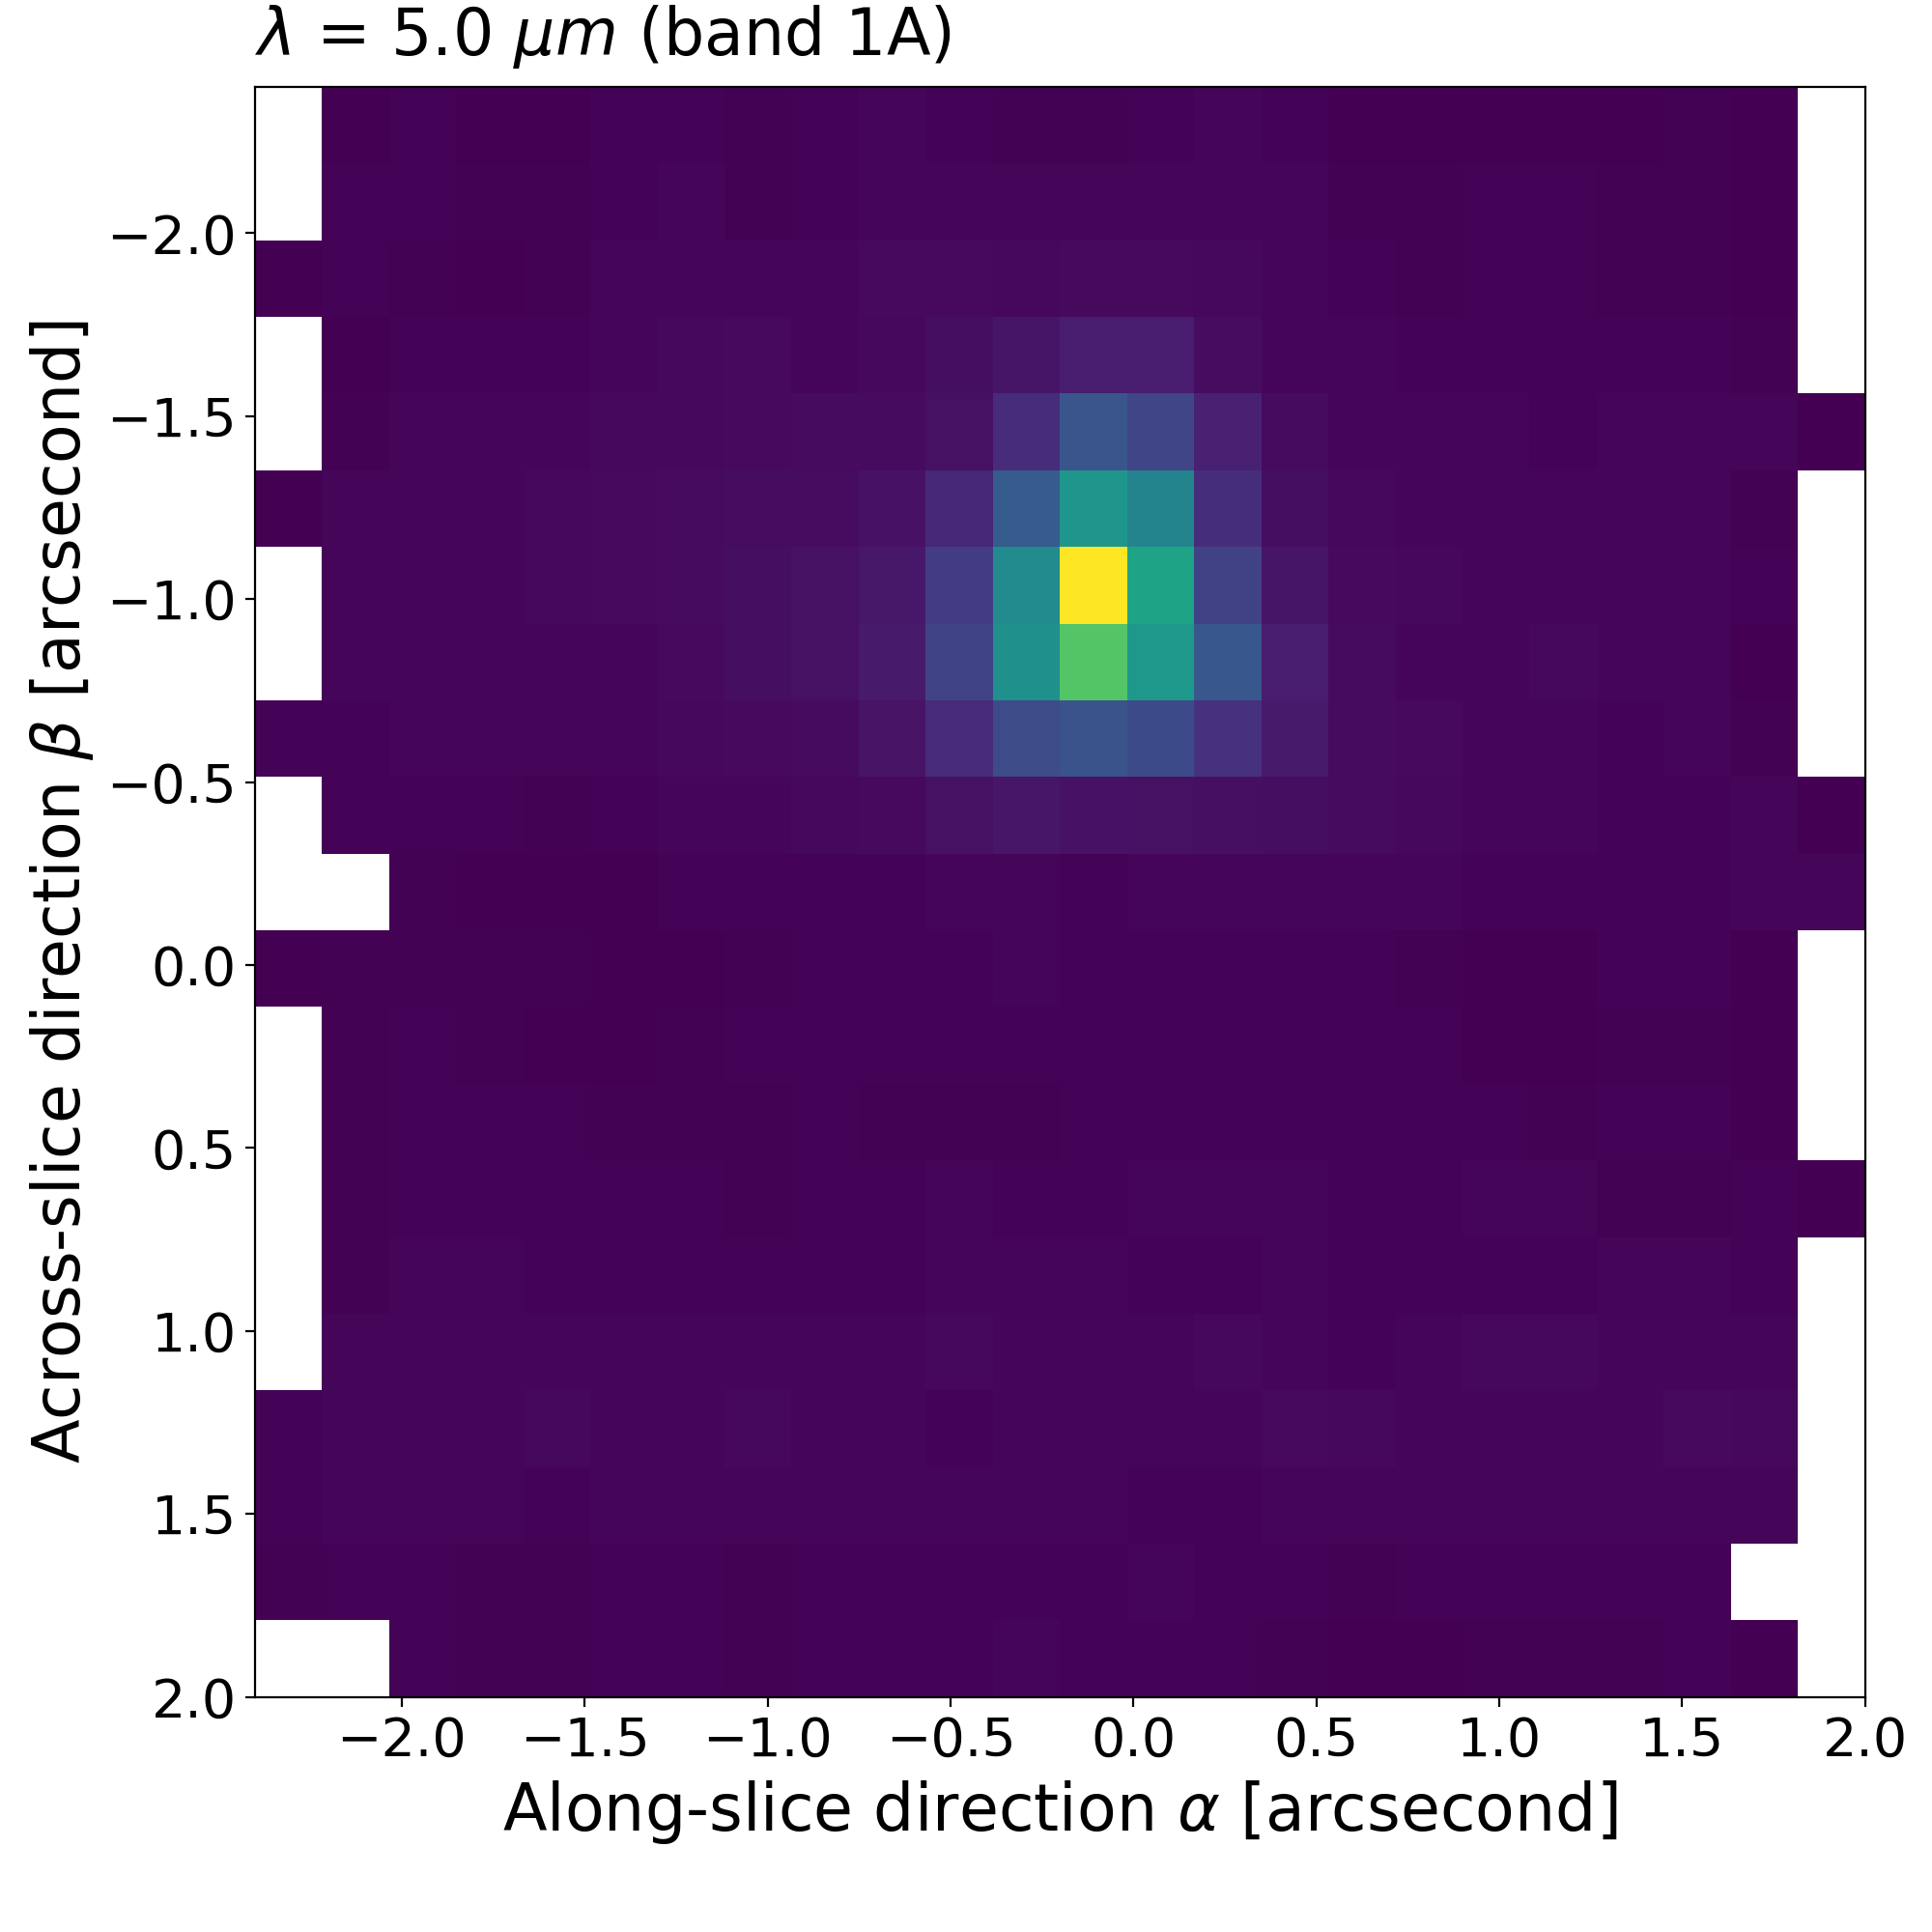

In [91]:
import numpy as np
cube_fits = fits.open('/Users/ioannisa/Desktop/MIRFM1T00012308_1_495_SE_2011-06-30T22h43m36_CUBE_CH1_A.fits')
cube_values = cube_fits[0].data.transpose(2,1,0) # flip data from Z,Y,X to X,Y,Z

#>get grid
NAXIS1,NAXIS2,NAXIS3 = cube_values.shape

alphastpix = cube_fits[0].header['CRPIX1'] # pixel nr
alpha_step = cube_fits[0].header['CDELT1'] # arcsec/pix
stalpha    = cube_fits[0].header['CRVAL1']-(alphastpix-1)*alpha_step # arcsec

betastpix = cube_fits[0].header['CRPIX2'] # pixel nr
beta_step = cube_fits[0].header['CDELT2'] # arcsec/pix
stbeta    = cube_fits[0].header['CRVAL2']-(betastpix-1)*beta_step # arcsec

alpha_slices = np.linspace(stalpha,stalpha+ (NAXIS1-1.5)*alpha_step,NAXIS1)
beta_slices  = np.linspace(stbeta,stbeta+ (NAXIS2-1.5)*beta_step,NAXIS2)

plt.figure(figsize=(10,10))
plt.imshow(cube_img, extent = (-2.4,2,2,-2.4), interpolation='none');
plt.annotate(r'$\lambda$ = 5.0 $\mu m$ (band 1A)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=24, color='k')
plt.xlabel(r'Along-slice direction $\alpha$ [arcsecond]',fontsize=24)
plt.ylabel(r'Across-slice direction $\beta$ [arcsecond]',fontsize=24)

# ax = plt.gca();
# ax = plt.gca();

# # Major ticks
# ax.set_xticks(arange(0, 24, 1));
# ax.set_yticks(arange(0, 21, 1));

# # Labels for major ticks
# ax.set_xticklabels(np.around(alpha_slices,1) );
# ax.set_yticklabels(np.around(beta_slices,1) );

# Minor ticks
ax.set_xticks(arange(.5, 24.5, 1), minor=True);
ax.set_yticks(arange(.5, 21.5, 1), minor=True);

# Gridlines based on minor ticks
plt.tight_layout()